In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
biometric1 = pd.read_csv("C:/Desktop/For_hackathons/NDH/datasets/api_data_aadhar_biometric/api_data_aadhar_biometric_0_500000.csv")
biometric2 = pd.read_csv("C:/Desktop/For_hackathons/NDH/datasets/api_data_aadhar_biometric/api_data_aadhar_biometric_500000_1000000.csv")
biometric3 = pd.read_csv("C:/Desktop/For_hackathons/NDH/datasets/api_data_aadhar_biometric/api_data_aadhar_biometric_1000000_1500000.csv")
biometric4 = pd.read_csv("C:/Desktop/For_hackathons/NDH/datasets/api_data_aadhar_biometric/api_data_aadhar_biometric_1500000_1861108.csv")

demo1 = pd.read_csv("C:/Desktop/For_hackathons/NDH/datasets/api_data_aadhar_demographic/api_data_aadhar_demographic_0_500000.csv")
demo2 = pd.read_csv("C:/Desktop/For_hackathons/NDH/datasets/api_data_aadhar_demographic/api_data_aadhar_demographic_500000_1000000.csv")
demo3 = pd.read_csv("C:/Desktop/For_hackathons/NDH/datasets/api_data_aadhar_demographic/api_data_aadhar_demographic_1000000_1500000.csv")
demo4 = pd.read_csv("C:/Desktop/For_hackathons/NDH/datasets/api_data_aadhar_demographic/api_data_aadhar_demographic_1500000_2000000.csv")
demo5 = pd.read_csv("C:/Desktop/For_hackathons/NDH/datasets/api_data_aadhar_demographic/api_data_aadhar_demographic_2000000_2071700.csv")

enroll1 = pd.read_csv("C:/Desktop/For_hackathons/NDH/datasets/api_data_aadhar_enrolment/api_data_aadhar_enrolment_0_500000.csv")
enroll2 = pd.read_csv("C:/Desktop/For_hackathons/NDH/datasets/api_data_aadhar_enrolment/api_data_aadhar_enrolment_500000_1000000.csv")
enroll3 = pd.read_csv("C:/Desktop/For_hackathons/NDH/datasets/api_data_aadhar_enrolment/api_data_aadhar_enrolment_1000000_1006029.csv")

In [4]:
biometric = pd.concat([biometric1, biometric2, biometric3, biometric4], ignore_index=True)
demographic = pd.concat([demo1, demo2, demo3, demo4, demo5], ignore_index=True)
enrolment = pd.concat([enroll1, enroll2, enroll3], ignore_index=True)

In [5]:
# renaming columns

biometric = biometric.rename(columns={
    "bio_age_5_17": "bio_5_17",
    "bio_age_17_": "bio_17_plus"
})

demographic = demographic.rename(columns={
    "demo_age_5_17": "demo_5_17",
    "demo_age_17_": "demo_17_plus"
})

enrolment = enrolment.rename(columns={
    "age_0_5": "enroll_0_5",
    "age_5_17": "enroll_5_17",
    "age_18_greater": "enroll_18_plus"
})

In [6]:
# normalizing state names 

state_fix_map = {
    "Andaman And Nicobar Islands": "Andaman and Nicobar Islands",
    "Andaman and Nicobar Islands": "Andaman and Nicobar Islands",
    "Andaman & Nicobar Islands": "Andaman and Nicobar Islands",

    "Dadra And Nagar Haveli": "Dadra and Nagar Haveli and Daman and Diu",
    "Dadra & Nagar Haveli": "Dadra and Nagar Haveli and Daman and Diu",
    "Dadra And Nagar Haveli And Daman And Diu": "Dadra and Nagar Haveli and Daman and Diu",
    "Dadra and Nagar Haveli and Daman and Diu": "Dadra and Nagar Haveli and Daman and Diu",

    "Daman And Diu": "Dadra and Nagar Haveli and Daman and Diu",
    "Daman & Diu": "Dadra and Nagar Haveli and Daman and Diu",
    "Daman and Diu": "Dadra and Nagar Haveli and Daman and Diu",

    "Jammu & Kashmir": "Jammu and Kashmir",
    "Jammu And Kashmir": "Jammu and Kashmir",
    "Jammu and Kashmir": "Jammu and Kashmir",

    "Nct Of Delhi": "NCT of Delhi",
    "Delhi": "NCT of Delhi",

    "Westbengal": "West Bengal",
    "West Bengal": "West Bengal",
}


def normalize_state(s):
    if pd.isna(s):
        return s
    s = s.strip()
    s = s.replace("\u00A0", " ")
    s = s.replace("-", " ")
    s = " ".join(s.split())
    s = s.title()
    return state_fix_map.get(s, s)

for df in [biometric, demographic, enrolment]:
    df["state"] = df["state"].apply(normalize_state)
    df["district"] = df["district"].str.strip().str.title()


In [7]:
# we merge on common geographic and time identifiers
# INNER JOIN ensures only matching records are used

merged = biometric.merge(
    demographic,
    on=["date", "state", "district", "pincode"],
    how="inner"
).merge(
    enrolment,
    on=["date", "state", "district", "pincode"],
    how="inner"
)

print("Merged dataset shape:", merged.shape)

Merged dataset shape: (763916, 11)


In [8]:
# these represent actual operational load.

merged["total_bio"] = merged["bio_5_17"] + merged["bio_17_plus"]
merged["total_demo"] = merged["demo_5_17"] + merged["demo_17_plus"]
merged["total_enroll"] = (merged["enroll_0_5"] + merged["enroll_5_17"] + merged["enroll_18_plus"])

# ratios help compare updates vs new enrolments

# | Pattern                  | Meaning                           |
# | ------------------------ | --------------------------------- |
# | High biometric, low demo | Device or biometric capture issue |
# | Low biometric, high demo | Migration / address churn         |
# | High both                | System stress / overload          |
# | Low both                 | Healthy Aadhaar ecosystem         |

merged["biometric_ratio"] = merged["total_bio"] / (merged["total_enroll"] + 1)
merged["demo_ratio"] = merged["total_demo"] / (merged["total_enroll"] + 1)

# | Ratio signal            | What can be done                              |
# | ----------------------- | --------------------------------------------- |
# | High biometric ratio    | Replace scanners, retrain operators           |
# | High demo ratio         | Deploy mobile camps, simplify address updates |
# | Rising ratio over time  | Early warning of stress                       |
# | Persistently high ratio | Audit processes                               |

In [9]:
# calculating z-scores
# high z-score means unusually high activity
# compared to national distribution.

merged["z_bio"] = (merged["total_bio"] - merged["total_bio"].mean()) / merged["total_bio"].std()
merged["z_demo"] = (merged["total_demo"] - merged["total_demo"].mean()) / merged["total_demo"].std()

# threshold: |z| > 3 indicates strong anomaly
anomalies = merged.loc[
    (merged["z_bio"].abs() > 3) |
    (merged["z_demo"].abs() > 3)
].copy()

print("Total anomalies detected:", anomalies.shape[0])

Total anomalies detected: 2163


In [10]:
# giving labels to different anomalies to categorize them for better understanding

anomalies.loc[
    (anomalies["biometric_ratio"] > 2) &
    (anomalies["biometric_ratio"] > anomalies["demo_ratio"]),
    "anomaly_type"
] = "Biometric Failure Hotspot"

anomalies.loc[
    (anomalies["demo_ratio"] > 2) &
    (anomalies["demo_ratio"] > anomalies["biometric_ratio"]),
    "anomaly_type"
] = "Migration / Mobility Hotspot"

anomalies["anomaly_type"] = anomalies["anomaly_type"].fillna("System Stress Zone")

anomalies.head(5)

,date,state,district,pincode,bio_5_17,bio_17_plus,demo_5_17,demo_17_plus,enroll_0_5,enroll_5_17,enroll_18_plus,total_bio,total_demo,total_enroll,biometric_ratio,demo_ratio,z_bio,z_demo,anomaly_type
0,01-04-2025,Rajasthan,Churu,331403,598,735,170,1401,316,141,12,1333,1571,469,2.836170,3.342553,13.621191,13.696772,Migration / Mobility Hotspot
1,01-04-2025,Rajasthan,Churu,331403,598,735,170,1401,316,141,12,1333,1571,469,2.836170,3.342553,13.621191,13.696772,Migration / Mobility Hotspot
2,01-04-2025,Karnataka,Bengaluru,560032,485,471,150,885,311,46,25,956,1035,382,2.496084,2.702350,9.697025,8.946148,Migration / Mobility Hotspot
3,01-04-2025,Karnataka,Bengaluru,560032,485,471,150,885,311,46,25,956,1035,382,2.496084,2.702350,9.697025,8.946148,Migration / Mobility Hotspot
4,01-04-2025,Gujarat,Mahesana,384001,364,577,155,818,120,15,25,941,973,160,5.844720,6.043478,9.540891,8.396635,Migration / Mobility Hotspot


In [11]:
# state-wise severity score
# "severity" combines biometric + demographic pressure.
# higher severity = more stress, inefficiency, or unusual activity.

# Severity < 1 → Healthy Zone
# Severity 1–2 → Watch Zone
# Severity 2–4 → Stress Zone
# Severity > 4 → Critical Hotspot

anomalies["severity"] = anomalies["biometric_ratio"] + anomalies["demo_ratio"]

state_severity = anomalies.groupby("state")["severity"].mean().reset_index()
anomalies.head(5)

,date,state,district,pincode,bio_5_17,bio_17_plus,demo_5_17,demo_17_plus,enroll_0_5,enroll_5_17,enroll_18_plus,total_bio,total_demo,total_enroll,biometric_ratio,demo_ratio,z_bio,z_demo,anomaly_type,severity
0,01-04-2025,Rajasthan,Churu,331403,598,735,170,1401,316,141,12,1333,1571,469,2.836170,3.342553,13.621191,13.696772,Migration / Mobility Hotspot,6.178723
1,01-04-2025,Rajasthan,Churu,331403,598,735,170,1401,316,141,12,1333,1571,469,2.836170,3.342553,13.621191,13.696772,Migration / Mobility Hotspot,6.178723
2,01-04-2025,Karnataka,Bengaluru,560032,485,471,150,885,311,46,25,956,1035,382,2.496084,2.702350,9.697025,8.946148,Migration / Mobility Hotspot,5.198433
3,01-04-2025,Karnataka,Bengaluru,560032,485,471,150,885,311,46,25,956,1035,382,2.496084,2.702350,9.697025,8.946148,Migration / Mobility Hotspot,5.198433
4,01-04-2025,Gujarat,Mahesana,384001,364,577,155,818,120,15,25,941,973,160,5.844720,6.043478,9.540891,8.396635,Migration / Mobility Hotspot,11.888199


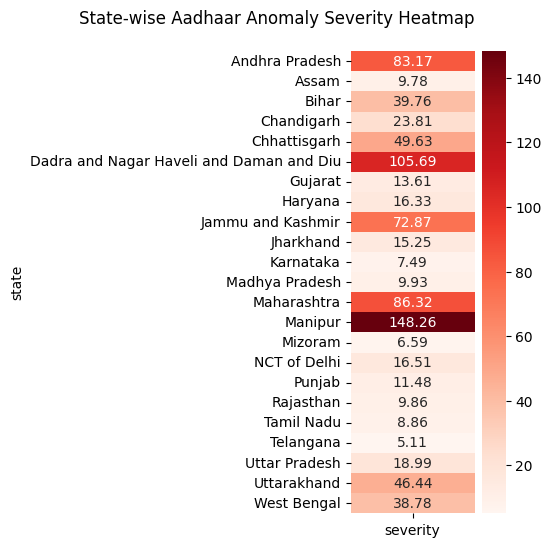

In [12]:
pivot = state_severity.pivot_table(
    values="severity",
    index="state"
)

plt.figure(figsize=(2,6))
sns.heatmap(pivot, cmap="Reds", annot=True, fmt=".2f")
plt.title("State-wise Aadhaar Anomaly Severity Heatmap", loc="right", pad=20)
plt.show()

In [13]:
# import json
# import plotly.express as px

# # Load GeoJSON
# with open("C:/Desktop/For_hackathons/NDH/india_states.geojson", "r", encoding="utf-8") as f:
#     india_geo = json.load(f)

# # geo_states = [f["properties"]["NAME_1"] for f in india_geo["features"]]
# # print(geo_states[:10])
# # Make sure state names match GeoJSON names
# state_severity["state"] = state_severity["state"].str.upper()

# fig = px.choropleth(
#     state_severity,
#     geojson=india_geo,
#     locations="state",
#     featureidkey="properties.NAME_1",
#     color="severity",
#     hover_name="state",
#     color_continuous_scale="Reds",
#     title="State-wise Aadhaar Anomaly Severity Heatmap"
# )

# fig.update_geos(fitbounds="locations", visible=False)
# fig.write_html("state_anomaly_heatmap.html")

In [14]:
# District-level aggregation
district_severity = (
    anomalies
    .groupby(["state", "district"], as_index=False)
    .agg({
        "biometric_ratio": "mean",
        "demo_ratio": "mean",
        "total_enroll": "sum",
        "total_bio": "sum",
        "total_demo": "sum"
    })
)

# severity score
district_severity["severity"] = (
    district_severity["biometric_ratio"] +
    district_severity["demo_ratio"]
)

# top stressed districts
district_severity_sorted = district_severity.sort_values(
    "severity", ascending=False
)

district_severity_sorted.head(10)


,state,district,biometric_ratio,demo_ratio,total_enroll,total_bio,total_demo,severity
140,Manipur,Thoubal,50.902485,161.044006,69,3728,10697,211.946491
135,Maharashtra,Yavatmal,53.895052,121.751157,202,10081,18865,175.646209
109,Maharashtra,Buldhana,52.751740,120.697207,63,2828,5454,173.448947
120,Maharashtra,Nanded,33.737226,134.554372,407,11919,40941,168.291598
215,West Bengal,Koch Bihar,3.333333,151.666667,4,20,910,155.000000
139,Manipur,Imphal West,43.563360,111.021627,65,1975,5305,154.584987
138,Manipur,Imphal East,35.792974,114.211928,72,2595,8447,150.004902
136,Manipur,Bishnupur,31.460243,96.682199,204,4501,12985,128.142442
209,West Bengal,Bankura,5.232576,122.624278,33,189,2840,127.856854
110,Maharashtra,Chandrapur,19.253999,105.084306,281,3432,6827,124.338305


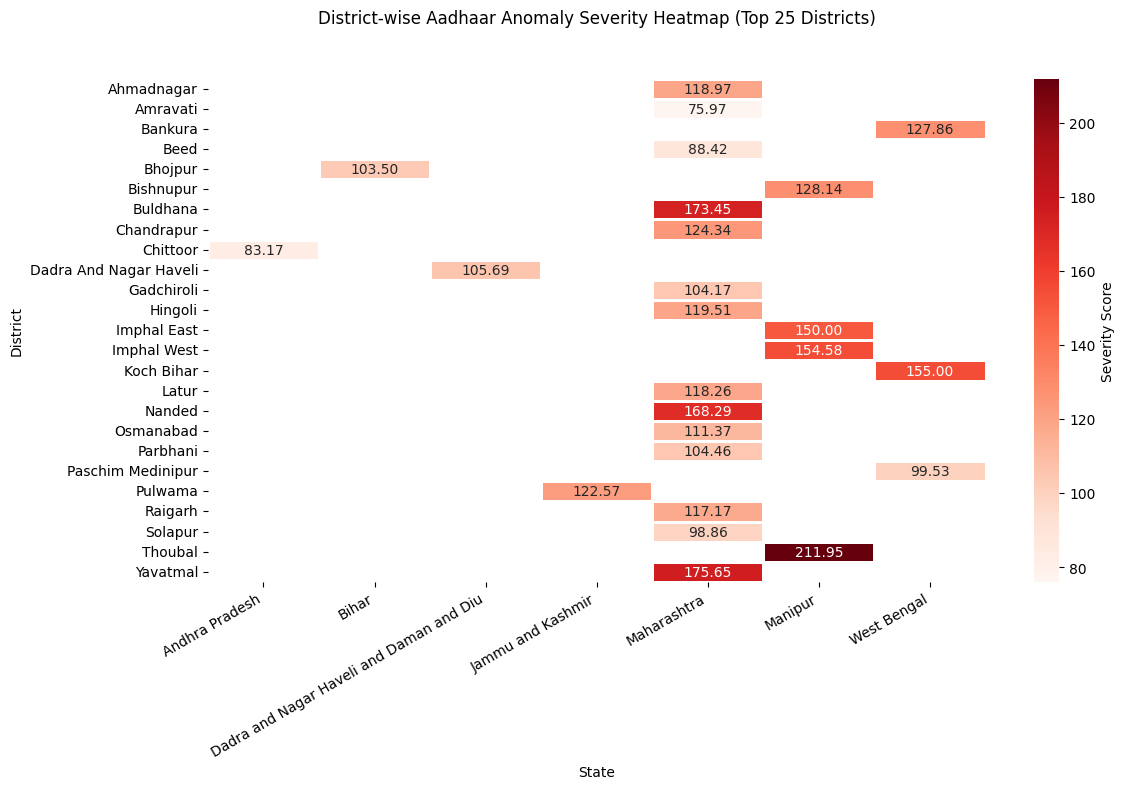

In [22]:
top_n = 25

top_districts = district_severity_sorted.head(top_n)

heatmap_data = top_districts.pivot(
    index="district",
    columns="state",
    values="severity"
)

plt.figure(figsize=(12, 8))

sns.heatmap(
    heatmap_data,
    cmap="Reds",
    annot=True,
    fmt=".2f",
    linewidths=1,
    cbar_kws={"label": "Severity Score"}
)

plt.title("District-wise Aadhaar Anomaly Severity Heatmap (Top 25 Districts)", pad=40)
plt.xlabel("State")
plt.ylabel("District")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()